<a href="https://colab.research.google.com/github/sayakpaul/Denoised-Smoothing-TF/blob/main/Train_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and imports

In [1]:
import os
import urllib
from getpass import getpass

user = input('User name: ')
password = getpass('Password: ')
password = urllib.parse.quote(password)
repo_address = input('Repo Address: ')
branch_name = input('Branch name: ')

cmd_string = 'git clone https://{}:{}@github.com/{}.git -b {}'.format(
    user, password, repo_address, branch_name
)

os.system(cmd_string)
cmd_string, password = "", ""

User name: sayakpaul
Password: ··········
Repo Address: sayakpaul/Denoised-Smoothing-TF
Branch name: main


In [1]:
import sys
sys.path.append("Denoised-Smoothing-TF")

from models import resnet20

from tensorflow.keras import layers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
try: 
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: 
    strategy = tf.distribute.MirroredStrategy() 

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of accelerators:  4


In [3]:
# from google.colab import auth
# auth.authenticate_user()

## Load the CIFAR-10 dataset

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

Total training examples: 50000
Total test examples: 10000


## Define constants

In [4]:
BATCH_SIZE = 128 * strategy.num_replicas_in_sync
EPOCHS = 200 
START_LR = 0.1 
AUTO = tf.data.AUTOTUNE

## Prepare data loaders

In [5]:
# Augmentation pipeline
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomCrop(32, 32),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ]
)

# Now, map the augmentation pipeline to our training dataset
train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .map(lambda x, y: (tf.image.convert_image_dtype(x, tf.float32), y), 
         num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Test dataset
test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .map(lambda x, y: (tf.image.convert_image_dtype(x, tf.float32), y), 
         num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Compute the mean and the variance of the training data for normalization
data_augmentation.layers[0].adapt(x_train/255.) # Notice the scaling step

## Model utilities

In [6]:
def lr_schedule(epoch):
    if epoch < int(EPOCHS * 0.25) - 1:
        return START_LR
    elif epoch < int(EPOCHS*0.5) -1:
        return float(START_LR * 0.1)
    elif epoch < int(EPOCHS*0.75) -1:
        return float(START_LR * 0.01)
    else:
        return float(START_LR * 0.001)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_schedule(epoch), verbose=True)

In [7]:
def get_model(n_classes=10):
    n = 2
    depth = n * 9 + 2
    n_blocks = ((depth - 2) // 9) - 1

    # The input tensor
    inputs = layers.Input(shape=(32, 32, 3))
    x = data_augmentation(inputs) # Normalize and augment

    # The Stem Convolution Group
    x = resnet20.stem(x)

    # The learner
    x = resnet20.learner(x, n_blocks)

    # The Classifier for 10 classes
    outputs = resnet20.classifier(x, 10)

    # Instantiate the Model
    model = tf.keras.Model(inputs, outputs)
    return model

In [8]:
# Serialize the initial model for better reproducibility
with strategy.scope():
    get_model().save("gs://denoised-smoothing-tf/initial_model_resnet20")

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

## Model training

In [9]:
# Optimizer and loss function.
optimizer = tf.keras.optimizers.SGD(learning_rate=START_LR, momentum=0.9)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

In [10]:
with strategy.scope():
    rn_model = tf.keras.models.load_model("gs://denoised-smoothing-tf/initial_model_resnet20")
    rn_model.compile(loss=loss_fn, optimizer=optimizer, metrics=["accuracy"])

history = rn_model.fit(train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    callbacks=[lr_callback])

Epoch 1/200

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
INFO:tensorflow:batch_all_reduce: 64 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 64 all-reduces with algorithm = nccl, num_packs = 1
98/98 [==============================] - 48s 77ms/step - loss: 2.7407 - accuracy: 0.3050 - val_loss: 3.4464 - val_accuracy: 0.1739
Epoch 2/200

Epoch 00002: LearningRateScheduler reducing learning rate to 0.1.
98/98 [==============================] - 4s 40ms/step - loss: 2.0492 - accuracy: 0.5223 - val_loss: 2.6184 - val_accuracy: 0.3323
Epoch 3/200

Epoch 00003: LearningRateScheduler reducing learning rate to 0.1.
98/98 [==============================] - 4s 39ms/step - loss: 1.7267 - accuracy: 0.6042 - val_loss: 2.8323 - val_accuracy: 0.3219
Epoch 4/200

Epoch 00004: LearningRateScheduler reducing learning rate to 0.1.
98/98 [==============================] - 4s 39ms/step - loss: 1.5095 - accuracy: 0.6541 - val_loss: 2.2621 - val_accuracy

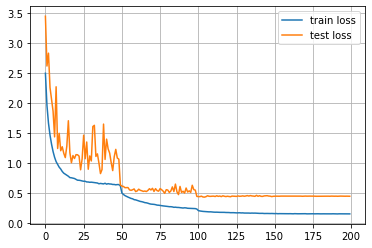

INFO:tensorflow:Assets written to: gs://denoised-smoothing-tf/resnet20_classifier/assets


In [11]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="test loss")
plt.grid()
plt.legend()
plt.show()

rn_model.save("gs://denoised-smoothing-tf/resnet20_classifier")

In [12]:
with strategy.scope():
    _, train_acc = rn_model.evaluate(train_ds, verbose=0)
    _, test_acc = rn_model.evaluate(test_ds, verbose=0)

print("Train accuracy: {:.2f}%".format(train_acc * 100))
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Train accuracy: 99.02%
Test accuracy: 90.64%
